 ```{attention}
    このNotebookはQiskit v0.44の仕様に合わせてコードを改変しています。
```

# 演習 3 - 量子エラー訂正

## 歴史的背景

ショアのアルゴリズムは量子コンピューターに価値あるユースケースを与えました。しかし、量子力学特有のノイズの多さから、このようなアルゴリズムを実行できるハードウェアを作るのは非常に困難でした。1995年、ショアは量子情報を複数の量子ビットで共有することで誤差を減らすという画期的な論文を発表しました。[1]

それ以来、数十年の間に大きな進歩がありました。新しい形式の誤り訂正符号が発見され、それらを中心とした大きな理論的枠組みが構築されました。1997年にKitaevが提案した表面符号が有力な候補として浮上し、その後も多くのバリエーションが登場しています。しかし、量子ハードウェアの特性に合わせてコードを調整するには、まだ多くの課題が残っています。[2]

この課題では、回路に人工的な「エラー」を挿入するケースを考えます。あなたの課題は、これらの追加ゲートを識別できるように回路を設計することです。

次に、作成した回路を実際のデバイスに実装する方法を考える必要があります。つまり、量子デバイス上の量子ビットのレイアウトに合わせてソリューションを調整します。量子もつれの状態にあるゲート（最もノイズの多いゲート）の数がどれだけ少ないかで採点されます。

### 参考文献
1. Shor, Peter W. "Scheme for reducing decoherence in quantum computer memory." Physical review A 52.4 (1995): R2493.
1. Dennis, Eric, et al. "Topological quantum memory." Journal of Mathematical Physics 43.9 (2002): 4452-4505.

## エラーがもたらす課題

エラーは、量子ビットに何らかの予期せぬ誤操作がなされたときに発生します。その影響で、回路がおかしくなってしまうのです。実機で動かしてみると、不思議な結果になることがありますが、それはすべてこのエラーのせいです。


予期せぬ誤操作はたくさんありますが、ここでは2種類のエラーしか存在しないと仮定します：ビット反転と位相反転です。


ビット反転は、`x`ゲートと同じ効果があります。1つの量子ビットの状態を0から1に反転させます。位相反転は、`z`ゲートと同じ効果を持ち、重ね合わせ状態に$-1$の位相を導入します。簡単に言うと、1つの量子ビットの$|+\rangle$状態を$|-\rangle$に反転させるもので、その逆も然りです。

任意のエラーをこの2つだけで考えることができるのは、任意のエラーは何らかの行列で表すことができ、任意の行列は行列$X$と$Z$で書くことができるからです。具体的には、ある適切に選択された値 $\alpha$, $\beta$, $\gamma$, $\delta$について、任意の1量子ビットの行列$M$を以下のように書き表すことができます。

$$
M = \alpha I + \beta X + \gamma XZ + \delta Z
$$

ゆえに、したがって、この行列をある単一の量子ビット状態$|\psi\rangle$に適用すると、次のようになります。

$$
M |\psi\rangle = \alpha |\psi\rangle + \beta X |\psi\rangle + \gamma XZ |\psi\rangle + \delta Z |\psi\rangle
$$

結果として得られる重ね合わせは、初期状態、エラーが単なるビット反転の場合の状態、位相反転の場合の状態、そして両方の場合の状態で構成されます。もし、ビット反転と位相反転のどちらが起きたかを測定する方法があれば、状態は1つの可能性に集約されます。そして、私たちの複雑なエラーは、単純なビットまたは位相の反転になります。

では、ビット反転なのか位相反転なのか（あるいはその両方なのか）をどうやって検出するのでしょうか。そして、それがわかったら、どうすればいいのか。これらの疑問を解決するのが、量子エラー訂正です。


##  極めて単純な例

多くの人が最初に書く量子回路の一つは、ふたつの量子ビットのもつれ（エンタングルメント）状態でしょう。今回の量子エラー訂正の旅も、まずはこの単純な例からみていきます。

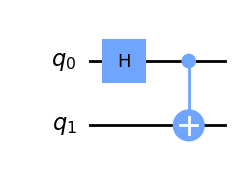

{'00': 510, '11': 514}

In [61]:
from qiskit import QuantumCircuit, Aer

# Make an entangled pair
qc_init = QuantumCircuit(2)
qc_init.h(0)
qc_init.cx(0,1)

# Draw the circuit
display(qc_init.draw('mpl'))

# Get an output
qc = qc_init.copy()
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

ここでは、回路を動作させたときに期待される結果、つまり、「00」と「11」が同じ確率で発生することがわかります。

しかし、同じ回路でも、手動でビット反転の「エラー」を挿入するとどうなるでしょうか。

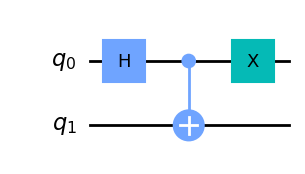

{'01': 522, '10': 502}

In [62]:
# Make bit flip error
qc_insert = QuantumCircuit(2)
qc_insert.x(0)

# Add it to our original circuit
qc = qc_init.copy()
qc = qc.compose(qc_insert)

# Draw the circuit
display(qc.draw('mpl'))

# Get an output
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

今度は結果が違っていて、`01`と`10`です。2つのビット値は、常に一致していたものが、常に一致しなくなっています。このようにして、エラーの影響を検出します。

もうひとつの検出方法は、さらにいくつかのゲートを使ってエンタングルメントを元に戻すことです。エラーがなければ、最初の$|00\rangle$の状態に戻ります。

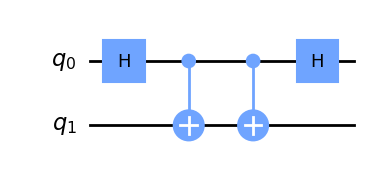

{'00': 1024}

In [63]:
# Undo entanglement
qc_syn = QuantumCircuit(2)
qc_syn.cx(0,1)
qc_syn.h(0)

# Add this after the error
qc = qc_init.copy()
qc = qc.compose(qc_syn)

# Draw the circuit
display(qc.draw('mpl'))

# Get an output
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

しかし、量子ビットの1つにエラーがあるとどうなるでしょうか？さまざまなエラーを挿入してみましょう。

初期化の `qc_init` 、エラーを挿入する `qc_insert` 、そして最終的な測定で明確な答えが得られるようにする `qc_syn` という回路です。

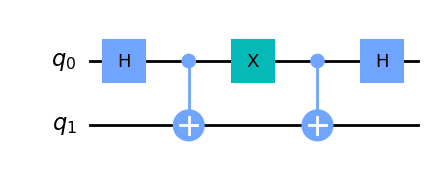

{'10': 1024}

In [64]:
# Define an error
qc_insert = QuantumCircuit(2)
qc_insert.x(0)

# Undo entanglement
qc_syn = QuantumCircuit(2)
qc_syn.cx(0,1)
qc_syn.h(0)

# Add this after the error
qc = qc_init.copy()
qc = qc.compose(qc_insert)
qc = qc.compose(qc_syn)

# Draw the circuit
display(qc.draw('mpl'))

# Get an output
qc.measure_all()
job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

出力を見ると、エラーの状況が正確にわかります。ビット反転と位相反転の両方が検出できます。左側のビット値は、ビット反転があった場合（つまり、`x(0)`または`x(1)`を挿入した場合）にのみ`1`となります。右側のビット値も同様に，位相反転があること（`z(0)`または`z(1)`が挿入されていること）を示しています。

このように、ビットや位相の反転を検出して区別する能力は非常に便利です。しかし、それだけでは十分ではありません。どのような種類のエラーが発生しているかがわかるだけで、どこでエラーが発生しているかはわかりません。より詳細な情報がなければ、これらの演算の影響を計算から取り除く方法を考えることはできません。したがって、量子エラー訂正には、もっと大きくて優れたものが必要なのです。

それを実装するのがあなたの役目です。ここには、あなたが提出しなければならないもののリストがあります。ここに書かれていることは、この後の例で説明されています。

````{admonition} 可逆性
:class: tip
量子コンピューターは、古典コンピューターとは異なり、演算過程を逆に戻して初期状態に戻すことができます。これが、可逆性と呼ばれる性質で、エラー検出に大きな利点があります。

通常の古典コンピューターでは、ANDやORといった論理演算を逆に戻しても、元の状態に戻すことができません。例えば、古典コンピューターのAND演算では、出力が0のとき、入力Aが0か1かを特定するのは難しいです。

[古典コンピューターのAND論理演算の場合]

| A | B | out |
|---|---|---|
| 0 | 0 | 0 |
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 1 | 1 |

一方、量子コンピューターでは、量子力学に基づいたユニタリー演算子を使用します。この演算子は可逆性を持ち、X、Z、H、CXゲートなどが全てこれに該当します。そのため、演算を逆に戻してエラーを検出することが可能です。

可逆性を利用して行った単純なエラー検出に加えて、量子コンピューターがエネルギーを保存する性質も存在します。これは、理論的に知られており、量子コンピューターが計算を行う際にエネルギー的にも有利であることを示唆しています。

参考文献：Bennett, Charles H. "Logical reversibility of computation." IBM journal of Research and Development 17.6 (1973): 525-532.
````

<div class="alert alert-block alert-success">

<b>目標</b>

2つの量子ビットの`x`と`z`のエラーを検出できる回路を作ってください。
自分で解決策を考えてもよいですし、あるいは、以下に示す完成間近の解答に手を加えるだけでも構いません。


</div>

<div class="alert alert-block alert-danger">
<b>提出すべきもの</b> 

* 2つの回路を供給する必要があります。
    * `qc_init`: 量子ビット(少なくとも2つ)を望ましい初期状態にします。
    * `qc_syn`: 量子ビットのサブセットを測定します。

* 挿入される人工的なエラーは、2つの特定の量子ビット上の `x` および `z` ゲートです。これに使用する2つの量子ビットを選択する必要があります（リスト `error_qubits` として提供されます）。

* 挿入されるエラーのセットは、16通りあります（エラーがないという些細なケースを含む）。`qc_syn` の測定結果は、それぞれに固有のビット文字列を出力する必要があります。これが満たされない場合、採点者はエラーメッセージ *'Please make sure the circuit is created to the initial layout.'* を返します。

* 採点システムはバックエンド `ibmq_tokyo` (引退したデバイス)用に完全な回路をコンパイルします。あなたのソリューションがデバイスに合わせて作られていることを示すために、この転置は `cx` ゲートの数を変えません。もし変更された場合は、エラーメッセージ *'Please make sure the circuit is created to the initial layout.'*を返します。
    
* トランスパイルの方法を誘導するために、デバイス上のどの量子ビットを回路内のどの量子ビットとして使用するかをトランスパイラーに伝える必要があります。これには、`initial_layout`リストが必要です。
    
* 以下の例のように、少し工夫することで有効な回答になります。
</div>

## よりよい例: 表面符号

In [65]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile

import qiskit.tools.jupyter
from qiskit.test.mock import FakeTokyo

/var/folders/z0/3n_ywd1d7ngfl6cd55kbcn0c0000gn/T/ipykernel_54025/3889398863.py:4: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeTokyo


この例では、code qubitsと呼ばれる5つの量子ビットを使用します。それらを記録するために、特別な量子レジスタを定義します。

In [66]:
code = QuantumRegister(5,'code')

さらに、シンドローム量子ビットと呼ばれる4つの量子ビットを追加します。

In [67]:
syn = QuantumRegister(4,'syn')

同様に、シンドローム量子ビットを測定する際に使用される4つの出力ビット用のレジスタを定義します。

In [68]:
out = ClassicalRegister(4,'output')

code qubitsは4つの三角形の角を形成し、シンドローム量子ビットはそれぞれの三角形の内側に存在するレイアウトを考えます。

```
c0----------c1
| \   s0   / |
|   \    /   |
| s1  c2  s2 |
|   /    \   |
| /   s3   \ |
c3----------c4
```

各三角形に対して、その3つの量子ビットにスタビライザー演算を関連付けます。両側の量子ビットのスタビライザー演算はZZZです。上と下の量子ビットには、XXXです。

シンドローム測定回路は、これらの観測値の測定に対応しています。これは表面符号(surface code)のスタビライザーと同様の方法で行われます（実際、このコードは表面符号(surface code)の小型版です）。


<div class="alert alert-block alert-danger">
 
<b>注意事項</b> 

コードを投稿する前に、トランスパイルに支障をきたすことのないようバリアを除去しておくようにしましょう。ここでは、視覚化のためにのみ提供されています。
</div>

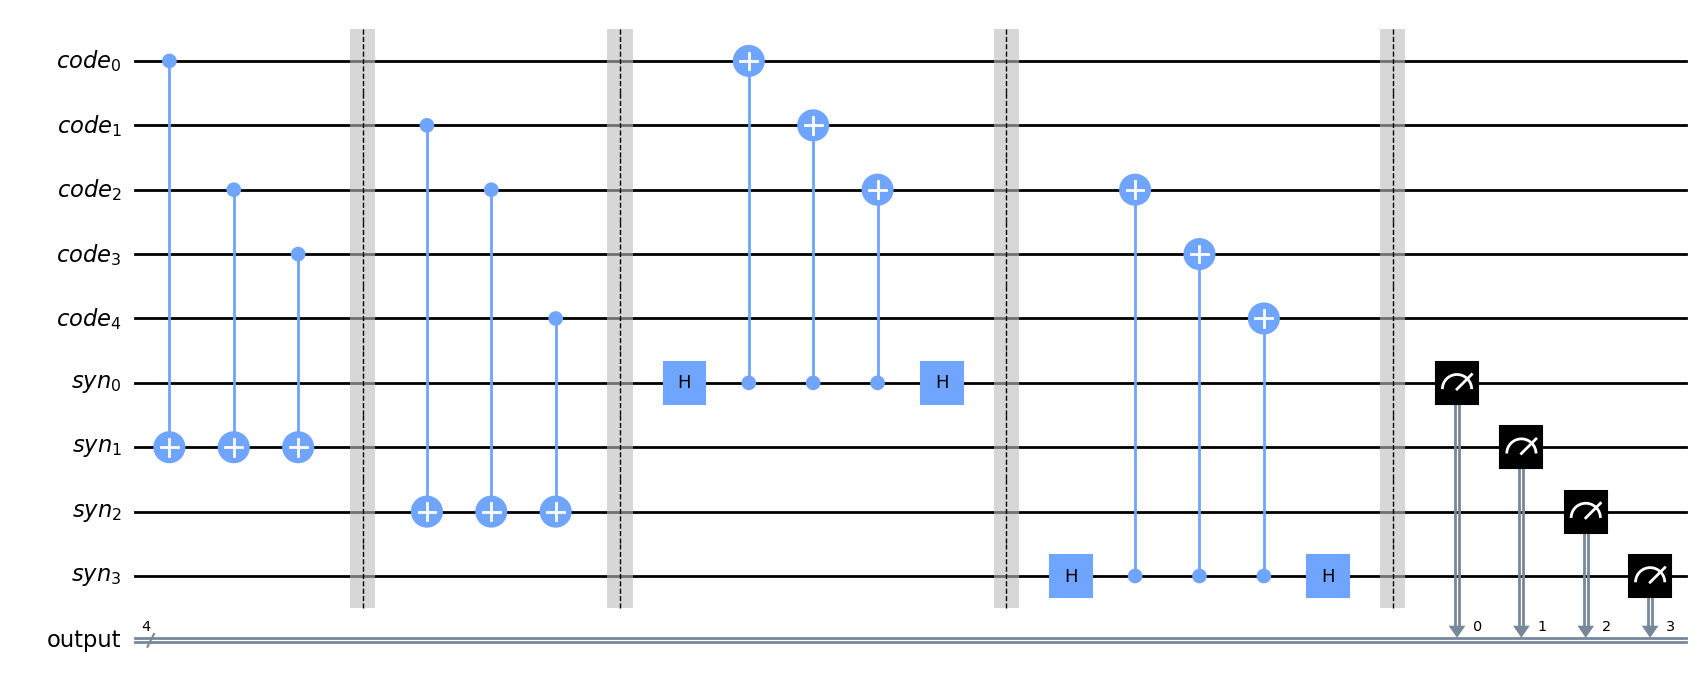

In [69]:
qc_syn = QuantumCircuit(code,syn,out)


# Left ZZZ
qc_syn.cx(code[0],syn[1])
qc_syn.cx(code[2],syn[1])
qc_syn.cx(code[3],syn[1])
qc_syn.barrier()

# Right ZZZ
qc_syn.cx(code[1],syn[2])
qc_syn.cx(code[2],syn[2])
qc_syn.cx(code[4],syn[2])
qc_syn.barrier()

# Top XXX
qc_syn.h(syn[0])
qc_syn.cx(syn[0],code[0])
qc_syn.cx(syn[0],code[1])
qc_syn.cx(syn[0],code[2])
qc_syn.h(syn[0])
qc_syn.barrier()

# Bottom XXX
qc_syn.h(syn[3])
qc_syn.cx(syn[3],code[2])
qc_syn.cx(syn[3],code[3])
qc_syn.cx(syn[3],code[4])
qc_syn.h(syn[3])
qc_syn.barrier()


# Measure the auxilliary qubits
qc_syn.measure(syn,out)
qc_syn.draw('mpl')

初期化回路は、これらの観測値の固有状態を準備し、シンドローム測定の出力が確実に`0000`になるようにします。

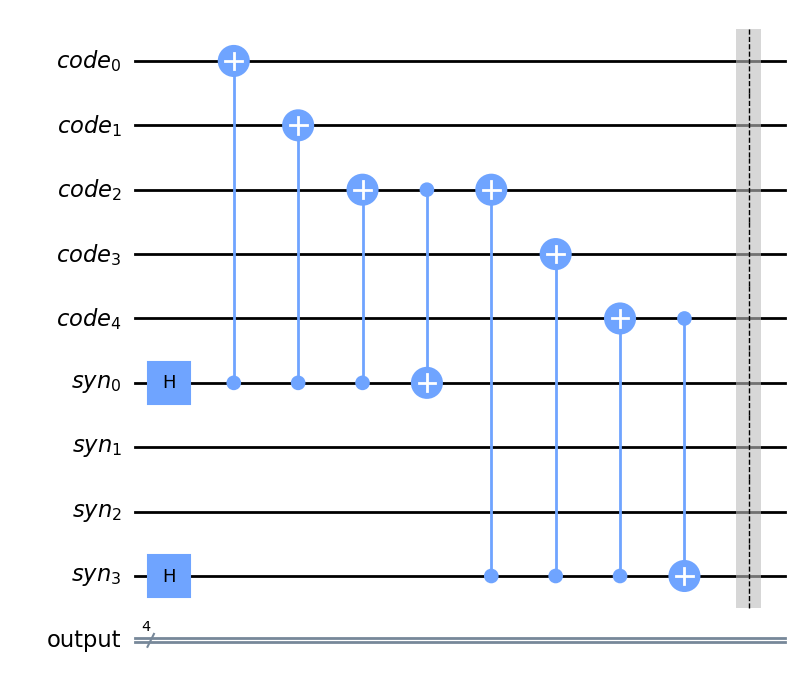

In [70]:
qc_init = QuantumCircuit(code,syn,out)

qc_init.h(syn[0])
qc_init.cx(syn[0],code[0])
qc_init.cx(syn[0],code[1])
qc_init.cx(syn[0],code[2])
qc_init.cx(code[2],syn[0])

qc_init.h(syn[3])
qc_init.cx(syn[3],code[2])
qc_init.cx(syn[3],code[3])
qc_init.cx(syn[3],code[4])
qc_init.cx(code[4],syn[3])

qc_init.barrier()
qc_init.draw('mpl')

事実か確認しましょう。

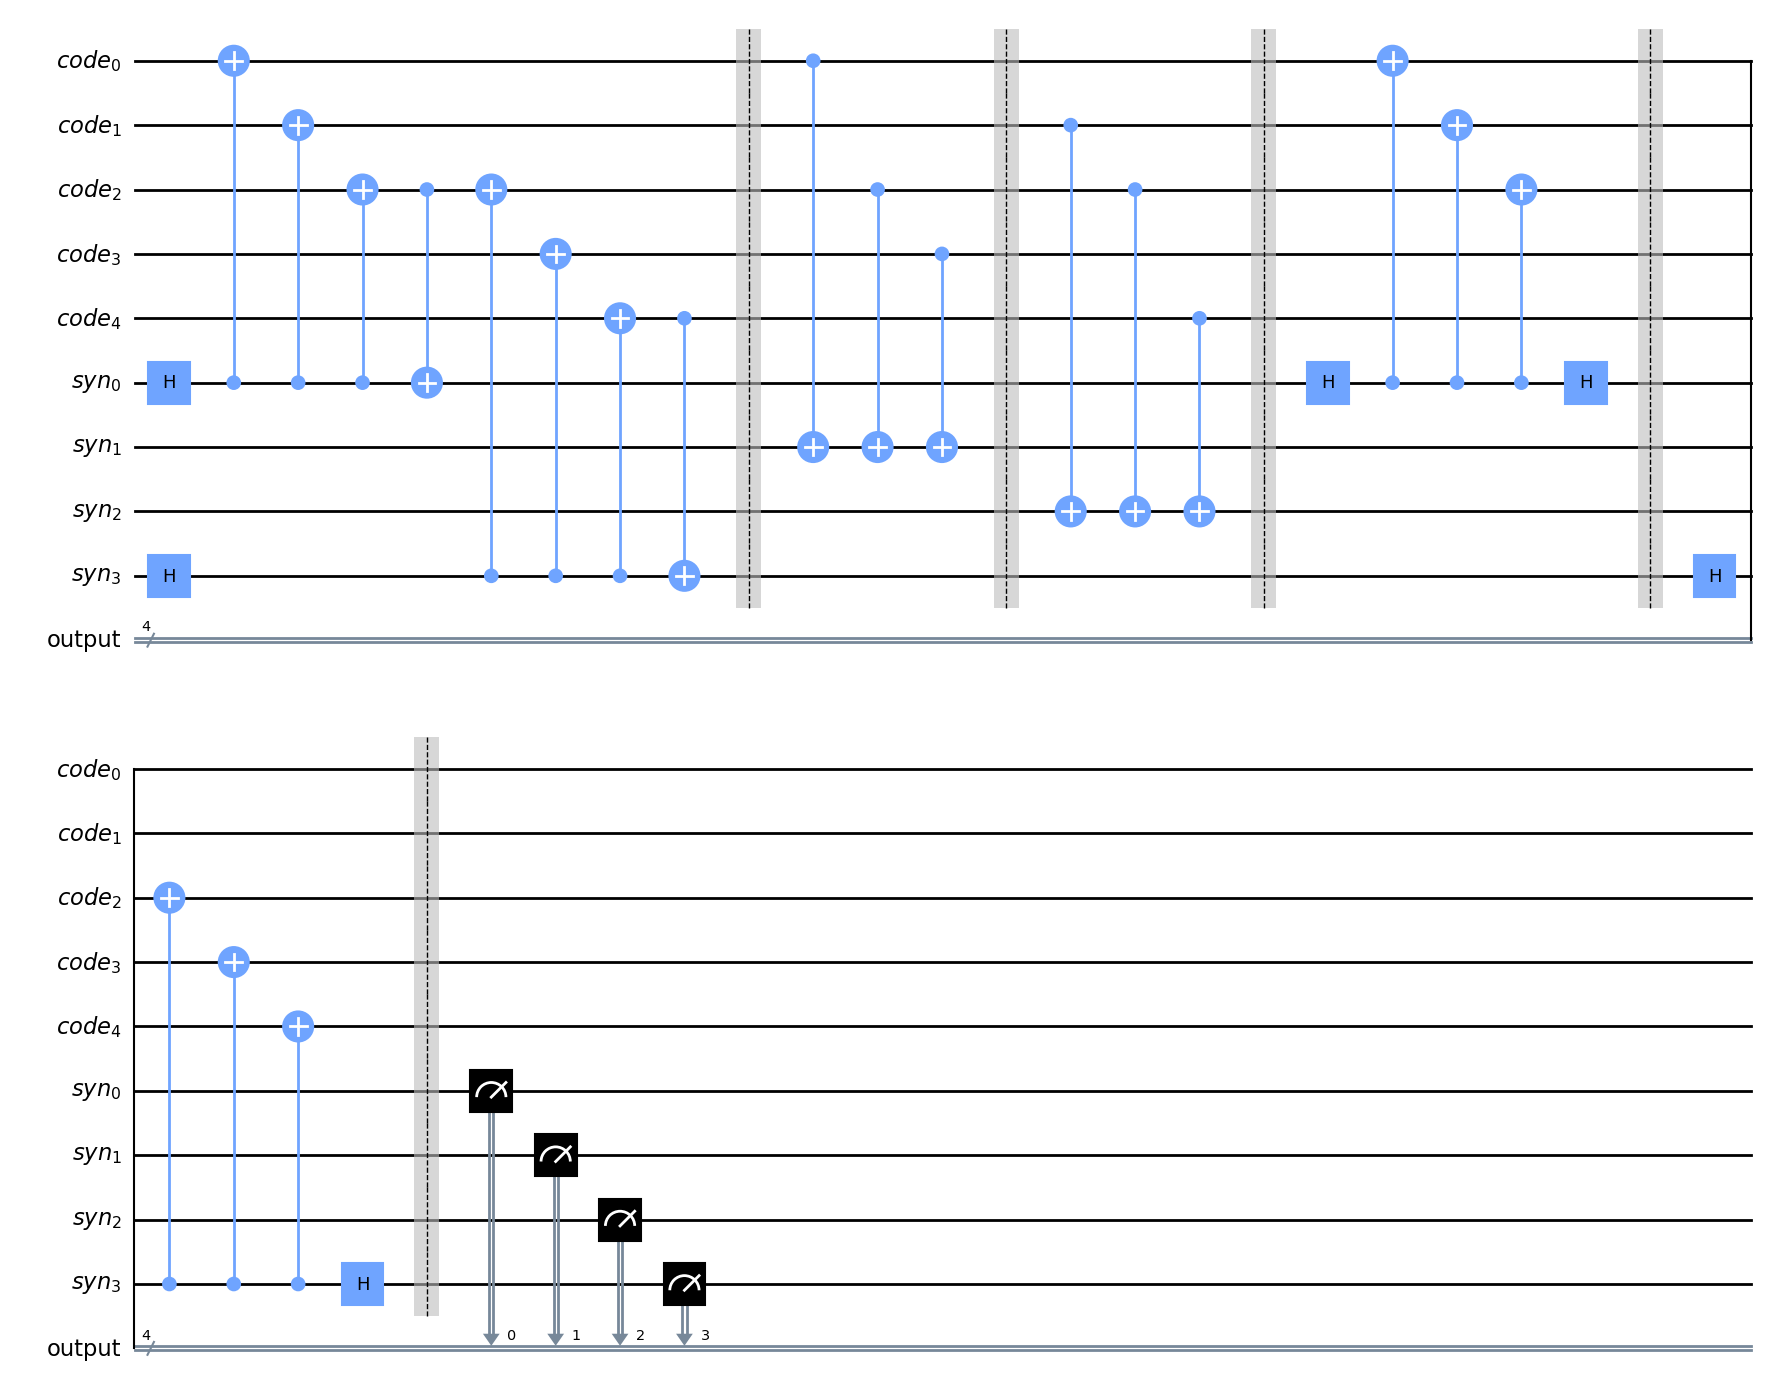

{'0000': 1024}

In [71]:
qc = qc_init.compose(qc_syn)
display(qc.draw('mpl'))

job = Aer.get_backend('qasm_simulator').run(qc)
job.result().get_counts()

それでは、2つの符号量子ビットに`x`と`z`のゲートを適用できる回路を作ってみましょう。そのためには、手持ちの5個の符号量子ビットのうち、有効条件に必要な2個に対応するものを選ぶ必要があります。

このコードでは、反対側の角を選択する必要があります。

In [72]:
error_qubits = [0,4]

ここで，0と4は，以下のリストの量子ビットの位置を示しており，量子ビット`code[0]`と`code[4]`です。

In [73]:
qc.qubits

[Qubit(QuantumRegister(5, 'code'), 0),
 Qubit(QuantumRegister(5, 'code'), 1),
 Qubit(QuantumRegister(5, 'code'), 2),
 Qubit(QuantumRegister(5, 'code'), 3),
 Qubit(QuantumRegister(5, 'code'), 4),
 Qubit(QuantumRegister(4, 'syn'), 0),
 Qubit(QuantumRegister(4, 'syn'), 1),
 Qubit(QuantumRegister(4, 'syn'), 2),
 Qubit(QuantumRegister(4, 'syn'), 3)]

コードが要求通りに動作しているかどうかをチェックするために、次のような関数を使って人工的なエラーを導入する回路を作ることができます。ここでは、例えば、`error_qubits[0]` の `x` を表す `x0` のように追加したいエラーを `errors` に単純なテキスト文字列としてリストアップしています。

In [74]:
def insert(errors,error_qubits,code,syn,out):

    qc_insert = QuantumCircuit(code,syn,out)

    if 'x0' in errors:
        qc_insert.x(error_qubits[0])
    if 'x1' in errors:
        qc_insert.x(error_qubits[1])
    if 'z0' in errors:
        qc_insert.z(error_qubits[0])
    if 'z1' in errors:
        qc_insert.z(error_qubits[1])
        
    return qc_insert

可能性のある16通りすべてではなく、1つのエラーが導入された4つのケースだけを見てみましょう。

In [75]:
for error in ['x0','x1','z0','z1']:
    
    qc = qc_init.compose(insert([error],error_qubits,code,syn,out)).compose(qc_syn)
    job = Aer.get_backend('qasm_simulator').run(qc)
    
    print('\nFor error '+error+':')
    counts = job.result().get_counts()
    for output in counts:
        print('Output was',output,'for',counts[output],'shots.')


For error x0:
Output was 0010 for 1024 shots.

For error x1:
Output was 0100 for 1024 shots.

For error z0:
Output was 0001 for 1024 shots.

For error z1:
Output was 1000 for 1024 shots.


ここでは、特定のエラーが発生したときに、出力の各ビットが `1` になることがわかります。左端のビットが `error_qubits[1]` で `z` を検出し、次のビットが `error_qubits[1]` で `x` を検出し、以下同様です。

<div class="alert alert-block alert-danger">
 
<b>注意事項</b> 

1. 一番左の出力は，`code[1]`の`z`を表しています．
2. 左から2番目の出力は `code[1]` の `x` を表しています。
3. 左から 3 番目の出力は、`code[0]` の `x` を表します。
4. 一番右の出力は `code[0]` 上の `z` を表す。
</div>

より多くのエラーが回路に影響を与えると、どのエラーが発生したかを明確に判断することが難しくなります。しかし、シンドロームの読み出しを継続的に行い、より多くの結果を得て、デコーディングというプロセスでデータを分析することで、エラーの影響を修正するのに十分な判断が可能となります。

このような検討事項は、今回の課題では扱わないかわりに、よりシンプルな事項でありながら同じくらい重要な事項にフォーカスします：エラーの数が少なければ少ないほど、またエラーの内容が単純であればあるほど、エラー訂正の質が向上します。そのためには、使用しているデバイスに合わせてエラー訂正の手順を調整する必要があります。

今回のチャレンジでは、`ibmq_tokyo`というデバイスを取り上げます。このデバイスの実際のバージョンはしばらく前に引退しましたが、モックバックエンドの一つとして今でも生きています。

In [76]:
# 以下のバックエンドを使ってください。
backend = FakeTokyo()
backend

<FakeTokyo('fake_tokyo')>

````{admonition} FakeTokyoの補足
:class: tip

Fake Tokyoは、20キュビットから成る仮想のコンピューターです。

もしもあなたがローカルでJupyter Notebookを使用している場合は、IBMのQuantum Labで`FakeTokyo`コマンドを入力すると、以下のような構造の情報や量子チェインのマップが表示されます。


```{image} ./resources/2021-spring-lab3-error-correction_faketokyo1.png
:alt: faketokyo1
:class: bg-primary mb-1
:width: 300px
:align: center
```

FakeTokyoに関するメソッドやパラメーターについては、[FakeTokyoのドキュメント](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.FakeTokyo)を参照してください。

バックエンド（コンピューター）に関する情報を取得するためには、backend.<Methods>のようなコマンドが使用できます。例えば、以下のようにバックエンドの名前を確認することができます。

例：
```python
backend.name()
```

また、configurationメソッドを使用すると、バックエンドの構成に関する情報を取得できます。以下は、カップリングマップ（バックエンド上で量子ビット間のチェインを示すもの）を確認する例です。

例：
```python
backend.configuration().coupling_map
```

````

今回の回路がどのように構成されているかを簡単に理解するために、2量子ビットゲートがいくつあるかを見てみましょう。

In [77]:
qc = qc_init.compose(qc_syn)
qc = transpile(qc, basis_gates=['u','cx'])
qc.num_nonlocal_gates()

20

これを`ibmq_tokyo`バックエンドにトランスパイルするとなると、2量子ビットのゲートを追加するというコストをかけてリマッピングを行う必要があります。

In [78]:
qc1 = transpile(qc,backend,basis_gates=['u','cx'], optimization_level=3)
qc1.num_nonlocal_gates()

/Users/jiwonju/Documents/qiskit/iqc-textbook/tutorial-env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/jiwonju/Documents/qiskit/iqc-textbook/tutorial-env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


23

これは、デバイス上のどの量子ビットをコードの量子ビットとして使用するのが最適かを検討することで、ある程度コントロールすることができます。`qc_syn`でコード内のどの量子ビットを2量子ビットゲートで接続する必要があるかを見ると、以下のような必要な接続グラフが得られます。

```
c0....s0....c1
:      :     :        
:      :     :
s1....c2....s2
:      :     :
:      :     :
c3....s3....c4
```

`ibmq_tokyo`上の量子ビットのセットではこれを提供できませんが、0,1,2,5,6,7,10,11,12のような特定のセットはこれに近いものがあります。そこで、`initial_layout`を設定して、トランスパイラにこれらを使うように指示することができます。



In [79]:
initial_layout = [0,2,6,10,12,1,5,7,11]

これらはトランスパイラに、デバイス上のどの量子ビットを回路内の量子ビットに使用するかを伝えます（`qc.qubits`に記載されている順番になります）。つまり、このリストの最初の5つのエントリーは、符号量子ビットとしてどの量子ビットを使用するかを回路に伝え、このリストの次の4つのエントリーは、同様にシンドローム量子ビットを伝えます。つまり、デバイス上の量子ビット0を`code[0]`、量子ビット2を`code[1]`というように使います。

では、これを使ってトランスパイルしましょう。

In [80]:
qc2 = transpile(qc,backend,initial_layout=initial_layout, basis_gates=['u','cx'], optimization_level=3)
qc2.num_nonlocal_gates()

26

トランスピレーションはランダムな処理ですが、初期レイアウトを用意しない場合に比べて、2量子ビットゲートの使用量が少なくなることがわかります（トランスピレーションはランダムな処理なので、それを確認するにはトランスピレーションコードを何度も再実行する必要があるかもしれません）。

とはいえ、適切に設計された誤り訂正方式は、リマッピングを一切必要としないはずです。使われているデバイスに合わせて書かれており、2量子ビットゲートの数は確実に一定でなければなりません。これが解答が成立するための条件です。ですから、単に`initial_layout`を用意するだけでなく、そのレイアウトに合わせて回路を設計する必要があります。

しかし、そこはあなたにお任せします！

````{admonition} 解答例
**初期レイアウトの設定によるエラー低減**

この問題では、初期レイアウト`initial_layout`を設定することで、回路上で2量子ビットゲート（CXゲート）で繋がっている量子ビット同士が、ランダムなtranspileを何度も試行しても変わらずに、バックエンドの量子チェイン設計上でも近くにいるようにしました。これにより、2量子ビットゲートの数を抑え、エラー率を軽減することにつながります。

```{image} ./resources/2021-spring-lab3-error-correction_faketokyo4.png
:alt: faketokyo4
:class: bg-primary mb-1
:width: 300px
:align: center
```

チャレンジに進む前に、初期レイアウトの設定がなぜ重要なのかを復習してみましょう。
初期レイアウトを設定しないと、回路上の量子ビット同士が設計上離れてしまい、無駄なCXゲートが増え、コストやエラー率が上昇してしまいます。これを防ぐために、transpileの前に初期レイアウトを手動で設定することが必要です。


**初期レイアウトの設定と回路の設計**
今回のチャレンジでは、初期レイアウトを用意した上で、さらに回路を設計することが必要です。具体的には、初期レイアウトを設定したとしても、設計上で繋がっていない量子ビット同士に対して、CXゲートの迂回経路を手動で指定することが求められます。これにより、設計上の不足を補完し、無駄なCXゲートを避けることができます。

```{image} ./resources/2021-spring-lab3-error-correction_faketokyo3.png
:alt: faketokyo3
:class: bg-primary mb-1
:width: 300px
:align: center
```

下の回答例で示されているqc_syn_aを見ると、初期レイアウトとFakeTokyoの設計上の情報を比較して、設計上で繋がっていない量子ビット同士に対してCXゲートを適切に迂回しています。


まとめると、初期レイアウトの設定と設計上で繋がっていない量子ビット同士に対するCXゲートの迂回指定を組み合わせることで、無駄なCXゲートを抑え、エラー率を効果的に軽減できます。
````

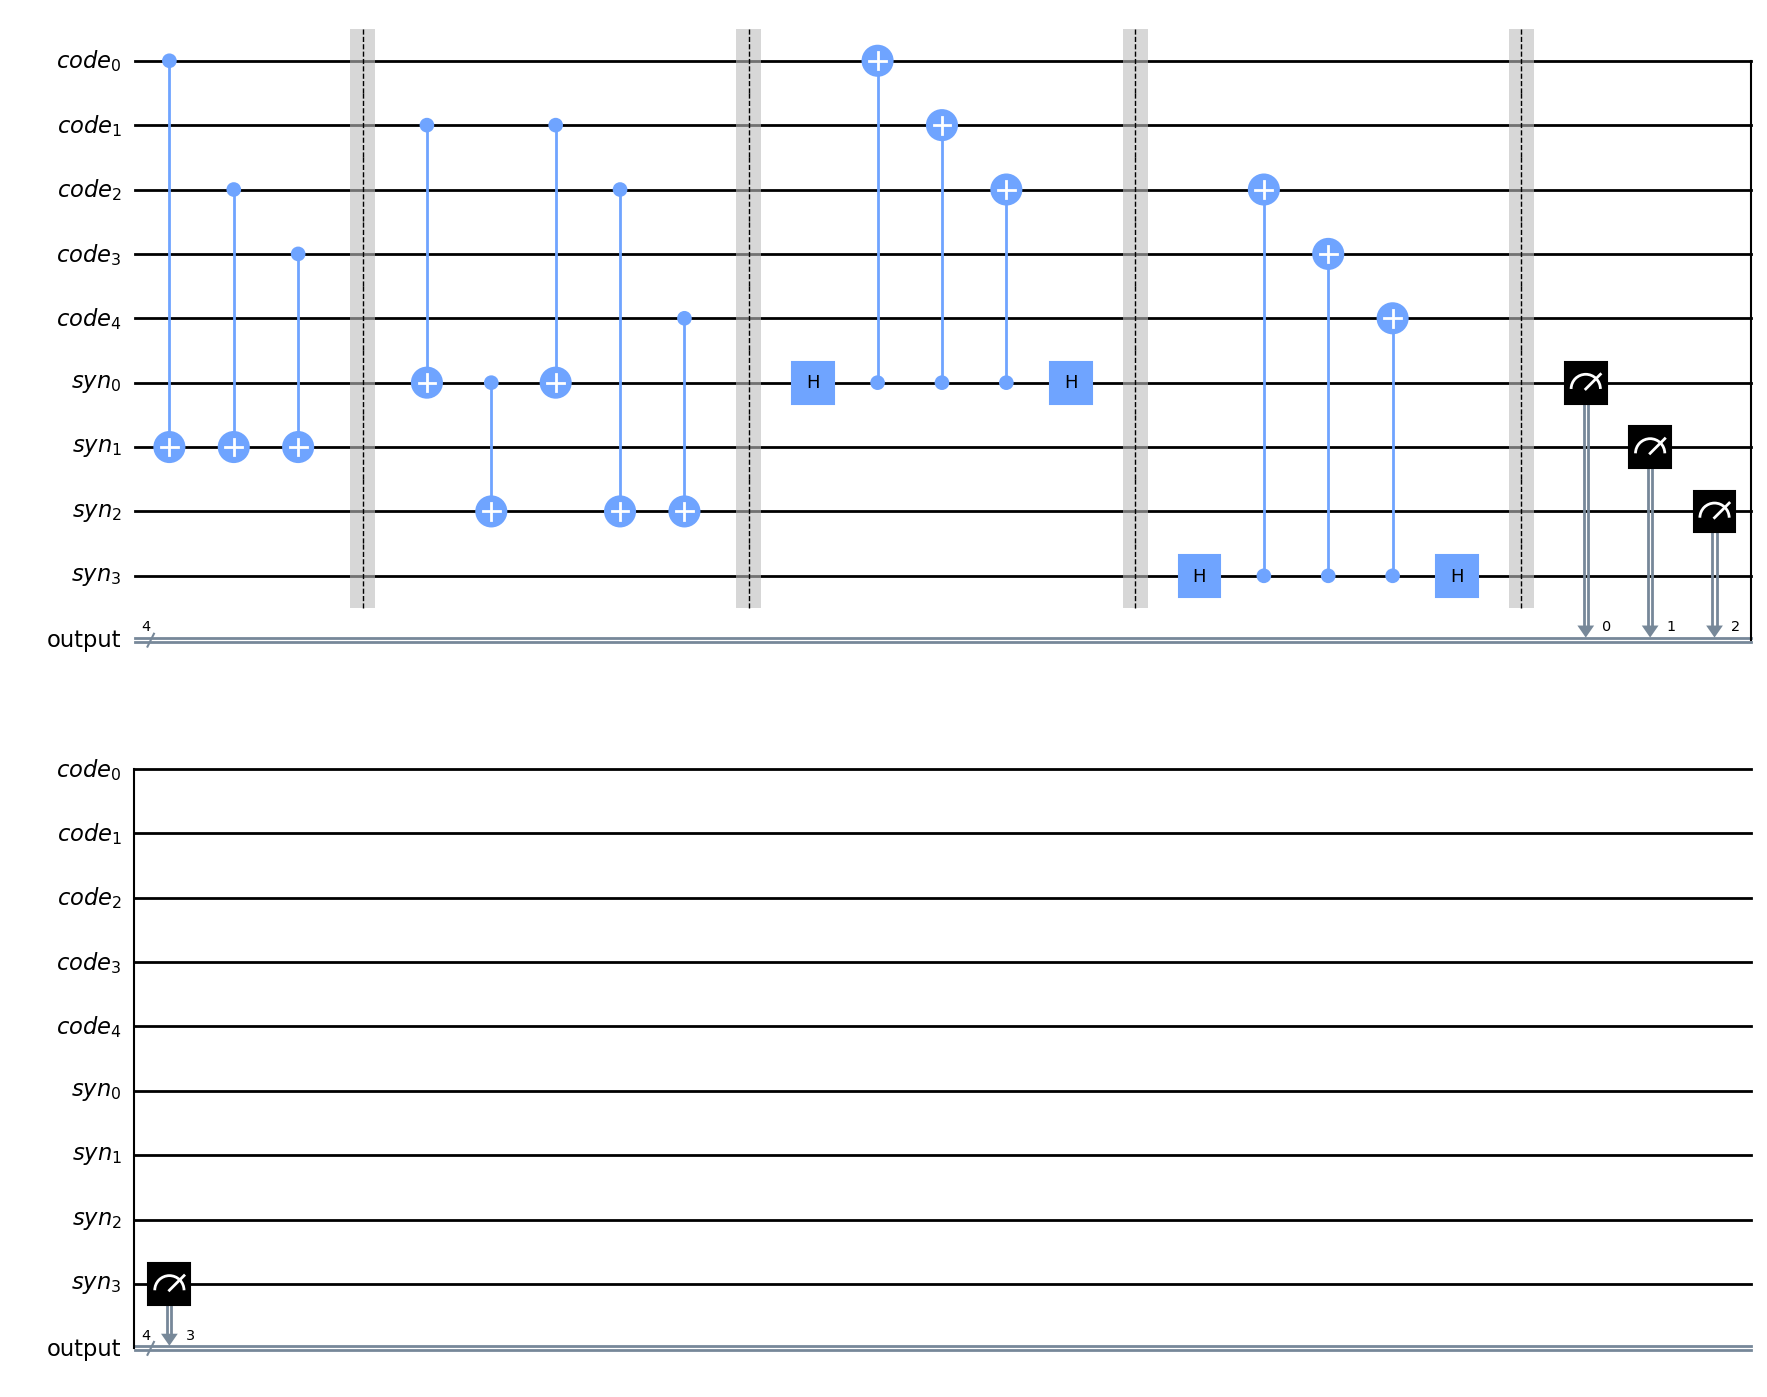

In [81]:
qc_syn_a = QuantumCircuit(code,syn,out)


# Left ZZZ
qc_syn_a.cx(code[0],syn[1])
qc_syn_a.cx(code[2],syn[1])
qc_syn_a.cx(code[3],syn[1])
qc_syn_a.barrier()

# Right ZZZ
# ----ここから----
# qc_syn2.cx(code[1],syn[2])　--> code[1] and syn[2]は、繋がっていない
qc_syn_a.cx(code[1],syn[0])
qc_syn_a.cx(syn[0],syn[2])
# 迂回のために使われた演算を戻しておくことも大事！
qc_syn_a.cx(code[1],syn[0])
# ----ここまで----
qc_syn_a.cx(code[2],syn[2])
qc_syn_a.cx(code[4],syn[2])
qc_syn_a.barrier()

# Top XXX
qc_syn_a.h(syn[0])
qc_syn_a.cx(syn[0],code[0])
qc_syn_a.cx(syn[0],code[1])
qc_syn_a.cx(syn[0],code[2])
qc_syn_a.h(syn[0])
qc_syn_a.barrier()

# Bottom XXX
qc_syn_a.h(syn[3])
qc_syn_a.cx(syn[3],code[2])
qc_syn_a.cx(syn[3],code[3])
qc_syn_a.cx(syn[3],code[4])
qc_syn_a.h(syn[3])
qc_syn_a.barrier()


# Measure the auxilliary qubits
qc_syn_a.measure(syn,out)
qc_syn_a.draw('mpl')

In [86]:
qc_a = qc_init.compose(qc_syn_a)
qc_a_t = transpile(qc_a,backend,initial_layout=initial_layout,basis_gates=['u','cx'], optimization_level=3)
qc_a_t.num_nonlocal_gates()

/Users/jiwonju/Documents/qiskit/iqc-textbook/tutorial-env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/jiwonju/Documents/qiskit/iqc-textbook/tutorial-env/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


22

````{admonition} 補足：transpileの結果確認
**CXゲートとエラーの重要性**

今回の問題では、CXゲートをレイアウトに合わせて指定することで、transpile後にCXゲートが常に22になることを確認しました。CXゲートは、例えばXゲートやZゲートのような単一のゲートより数倍もコストがかかります。そのため、CXゲートの数を減らすことはエラーを減少させる上で非常に重要なポイントです。

**実際に確認してみよう！**

もし興味があれば、CXゲートを修正する前のtranspileをprintしてみましょう！transpileは戻り値がList型で、printするとtranspileされた回路が見られます。分かりやすくするために、`qc_syn`のみtranspileをして確認してみましょう。

[CXゲートを修正する前]
```python
qc_syn_t = transpile(qc_syn,backend,initial_layout=initial_layout,basis_gates=['u','cx'], optimization_level=3)
print(qc_syn_t.num_nonlocal_gates())
print(qc_syn_t)
```

下は、私の環境でCXゲートを修正した後のqc_synをtranspileした結果の一部を抜粋したものです。

```python
                   │             ░ ┌───┐     ┌───┐     ░ »...« ┌───┐     ┌───┐└─┬─┘       ░ »
      syn_0 -> 1 ──┼─────────────░─┤ X ├──■──┤ X ├──■──░─»...« ┤ X ├──■──┤ X ├──■────■────░─»
                   │             ░ └─┬─┘┌─┴─┐└─┬─┘  │  ░ »...« └─┬─┘┌─┴─┐└─┬─┘     ┌─┴─┐  ░ »
     code_1 -> 2 ──┼─────────────░───■──┤ X ├──■────┼──░─»...« ──■──┤ X ├──■───────┤ X ├──░─»
                   │             ░      └───┘       │  ░ »...«      └───┘          └───┘  ░ »
```


結果を見ると、code[1]とsyn[2]を繋ぐために、syn[0]に迂回していきますが、その中で必要のないCXゲートが浪費されていることが確認できます。transpile毎に結果は異なるかもしれませんが、例えば私の環境では、code[1]とsyn[0]の間にお互いに相殺されるCXゲートが4個もかかっていました。

```{image} ./resources/2021-spring-lab3-error-correction_faketokyo5.png
:alt: faketokyo5
:class: bg-primary mb-1
:width: 300px
:align: center
```


この結果を、CXゲートを修正した後のqc_synをtranspileしたものの結果と比較してみましょう！

[CXゲートを修正した後]
```python
qc_syn_t = transpile(qc_syn,backend,initial_layout=initial_layout,basis_gates=['u','cx'], optimization_level=3)
print(qc_syn_t.num_nonlocal_gates())
print(qc_syn_t)
```


````

```{admonition} おまけ
:class: tip
違う構成を持っている他のバックエンドを使ってchallengeしてみましょう！
[FakeSingapore](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.FakeSingapore)を使ってみましょう。
```

```{admonition} エラー検出確認
:class: tip
上で`insert()`関数や`error_qubits`を使ったエラー検出コードを覚えていますか？今回も同様に、そのコードを使用することで、qc_syn_a回路が正しく組まれ、エラーが適切に検出されているかを確認できます。
```

In [83]:
error_qubits = [0,4]
for error in ['x0','x1','z0','z1']:
    
    qc = qc_init.compose(insert([error],error_qubits,code,syn,out)).compose(qc_syn_a)
    job = Aer.get_backend('qasm_simulator').run(qc)
    
    print('\nFor error '+error+':')
    counts = job.result().get_counts()
    for output in counts:
        print('Output was',output,'for',counts[output],'shots.')


For error x0:
Output was 0010 for 1024 shots.

For error x1:
Output was 0100 for 1024 shots.

For error z0:
Output was 0001 for 1024 shots.

For error z1:
Output was 1000 for 1024 shots.


## Additional information

**Created by:** James Wootton, Rahul Pratap Singh

**翻訳者:** 小林有里

**Version:** 1.0.0